In [1]:
# Execution of this entire notebook should take around 4-8 minutes
# All the imports

import numpy as np
import itk
import vtk
import itkwidgets
import math

In [2]:
# Fetch the files

FIXED_MESH_FILE  = r'data/A_J_skull_.ply'
MOVING_MESH_FILE = r'data/Ark_J_skull_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/A_J_skull_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/Ark_J_skull_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [3]:
# Clean the mehes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path,pixel_type=itk.D) for path in vtk_paths]

In [4]:
# Convert meshes to images for performing moment based initialization

itk_images = [itk.triangle_mesh_to_binary_image_filter(mesh,
                                                       origin=[0,0,0],
                                                       spacing=[0.5,0.5,0.5],
                                                       size=[50,50,50])
              for mesh in itk_meshes]

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [5]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]


movingMesh = itk_transformed_meshes[0]
fixedMesh = itk_transformed_meshes[1]

itk.meshwrite(movingMesh, 'movingMesh.vtk')
itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [6]:
# Perform RANSAC ICP

def ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, convergance_value):
    all_points1 = itk.array_from_vector_container(movingMesh.GetPoints())
    all_points2 = itk.array_from_vector_container(fixedMesh.GetPoints())
    
    # Create Meshes with reduced number of points
    mesh_fixed  = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()
    
    random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    p1 = all_points1[random_indices, :]
    mesh_fixed.SetPoints(itk.vector_container_from_array(p1.flatten()))
    
    random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    p2 = all_points2[random_indices, :]
    mesh_moving.SetPoints(itk.vector_container_from_array(p2.flatten()))
    
    best_score = 100000
    best_result = None
    best_transform = None
    
    TransformType = itk.Euler3DTransform[itk.D]
    transform = TransformType.New()
    transform.SetIdentity()
    
    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    
    e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
    
    optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(5)
    optimizer.SetMaximumStepSizeInPhysicalUnits( 0.5 )
    optimizer.SetMinimumConvergenceValue( 0.0 )
    optimizer.SetConvergenceWindowSize( 5 )
    
    ps1 = itk.Mesh[itk.D, 3].New()
    ps2 = itk.Mesh[itk.D, 3].New()
    
    for i in range(number_of_iterations):
        random_indices = np.random.choice(all_points1.shape[0], size=number_of_ransac_points)
        p1 = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0], size=number_of_ransac_points)
        p2 = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))
        
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
        
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()
        
        current_transform    = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(mesh_moving, transform=current_transform)
        
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()
        
        current_value = e_metric.GetValue()
        
        if current_value < best_score:
            best_score     = current_value
            best_result    = itk_transformed_mesh
            best_transform = current_transform
        
        if convergance_value > 0 and best_score < convergance_value:
            break
    
    print('Best Score ', best_score)
    itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=best_transform)
    return itk_transformed_mesh

number_of_iterations    = 10000
number_of_ransac_points = 200
mesh_sub_sample_points  = 5000
convergence_value       = 0.3

itk_transformed_mesh = ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, convergence_value)
itk.meshwrite(itk_transformed_mesh, 'ransacICPResult1.vtk')

number_of_iterations    = 10
number_of_ransac_points = 10000
mesh_sub_sample_points  = 20000
convergence_value       = -1

itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, convergence_value)

itk.meshwrite(itk_transformed_mesh, 'ransacICPResult2.vtk')

Best Score  0.29446762628525247
Best Score  0.23335946720210782


In [7]:
# Visualize the results after RANSAC ICP

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

from itkwidgets import view

m1 = readvtk('fixedMesh.vtk')
m2 = readvtk('movingMesh.vtk')
m3 = readvtk('ransacICPResult1.vtk')
m4 = readvtk('ransacICPResult2.vtk')

view(geometries=[m1, m2, m3, m4])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [8]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 0.01
numberOfIterations = 10

movingMesh = itk.meshread('ransacICPResult2.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 5
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')

shiftScaleEstimator = itk.RegistrationParameterScalesFromPhysicalShift[MetricType].New()
shiftScaleEstimator.SetMetric(metric)
shiftScaleEstimator.SetVirtualDomainPointSet(metric.GetVirtualTransformedPointSet())


optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template.D.New()
optimizer.SetNumberOfIterations( numberOfIterations )
optimizer.SetScalesEstimator( shiftScaleEstimator )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numberOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

Number of Points are
156161
180796
Spacing  0.5352228802042572
minBounds  [ -4.04382372  -6.05604839 -12.0168047 ]
maxBounds  [ 4.73284292  5.96511984 10.22325993]
TSD Metric Created
Number of Transform Parameters  375
Registration Object created
Initial Value of Metric  0.05494634379861478
Metric: 0.054946344
Metric: 0.053162787
Metric: 0.048590411
Metric: 0.046942864
Metric: 0.046799173
Metric: 0.045978025
Metric: 0.045837093
Metric: 0.045938914
Metric: 0.04549378
Metric: 0.047124534
Final Value of TSD Metric  0.04712453390963223
Euclidean Metric Before TSD Deformable Registration  0.1481529810249547
Euclidean Metric After TSD Deformable Registration  0.12335342846631508


# Visualize the fixed mesh, moving mesh and the registered mesh
<img src="https://user-images.githubusercontent.com/1044135/161844315-e902d24c-3192-401a-a8aa-77104f940965.png" width=600 height=600 />

In [9]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

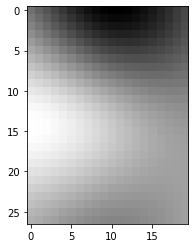

In [11]:
# Visualized the Displacement Field obtained from BSpline Transform

import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')